In [69]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
# ============================== Do not edit this shell ==========================================

# Dataset Definition

import csv
import numpy as np
import pandas as pd
import torch

from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0], dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img
        
# ============================== Do not edit this shell ==========================================

In [2]:
# Library Importation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.optim import Adam
from PIL import Image
from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import models
from torchsummary import summary as Summary
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

In [50]:
# # # Load dataset into python variable
# input_transform = transforms.Compose([Resize(32),RandomHorizontalFlip(),ToTensor()])

In [150]:
# Hyper Parameter
## Data Loader
batch_size = 45

## Model
hidden_layer = 10

## Learning
logging_dispfig = True
maximum_epoch = 70
learning_rate = 0.002


# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')


# Prepare dataset
root = './'
train_data = CharDataset(root, train=True, transform=ToTensor())
train_data, valid_data = random_split(train_data, [round(len(train_data)*0.9), round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=ToTensor())

GPU will be used in training/validation.


===================== Check the data =========================

Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Content of Y (Label, type=<class 'torch.Tensor'>) = 9
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


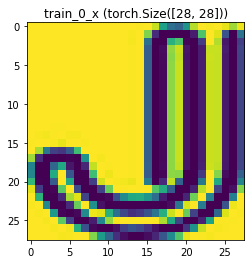

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([45, 1, 28, 28]) / Y.shape = torch.Size([45])

Y[0:45] = tensor([7, 2, 9, 4, 3, 8, 3, 6, 0, 2, 9, 9, 3, 6, 2, 3, 3, 6, 4, 6, 7, 5, 3, 4,
        8, 3, 4, 8, 7, 7, 9, 6, 6, 9, 7, 5, 6, 2, 3, 4, 5, 0, 9, 7, 2])


In [151]:
# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')
preview_index = 0

In [152]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False #false면 freeze, True면 CNN파트의 pre_trained weights를 그대로 쓰겟다는뜻
            #False면 back prop해도 CNN까지 안가고 classifier의 weight만 업뎃
            
def init_model(model_name, num_classes, feature_extract, use_pretrained=True): #feature_extrace느 boolean
    global net, loss_fn, optim
    
    # get CNN model from PyTorch Model Zoo
    if model_name == "resnet":
        """ Resnet18
        """
        net = models.resnet18(pretrained=use_pretrained) #pretained 불러오는거 추가
        set_parameter_requires_grad(net, feature_extract)
        net.conv1 = nn.Conv2d(1,64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias = False)
        
#         net.relu = nn.LeakyReLU(inplace=True)
#         net.layer1[0].relu = nn.LeakyReLU(inplace=True)
#         net.layer1[1].relu = nn.LeakyReLU(inplace=True)
#         net.layer2[0].relu = nn.LeakyReLU(inplace=True)
#         net.layer2[1].relu = nn.LeakyReLU(inplace=True)
#         net.layer3[0].relu = nn.LeakyReLU(inplace=True)
#         net.layer3[1].relu = nn.LeakyReLU(inplace=True)
#         net.layer4[0].relu = nn.LeakyReLU(inplace=True)
#         net.layer4[1].relu = nn.LeakyReLU(inplace=True)
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes) #내가가진 class 개수만큼 바꿔주는거
        input_size = 224
        

    elif model_name == "alexnet":
        """ Alexnet
        """
        net = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        net = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        net.conv1 = nn.Conv2d(1,64, kernel_size = (3,3), stride = (1,1), padding = (3,3), bias = False)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        net = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        net.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        net = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        net = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Choose Model between [resnet, alexnet, vgg, squeezenet, densenet, inception]")
        return 
    
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

    return input_size

In [153]:
# # Memory cleaner to prevent CUDA out of memory error
# def clear_memory():
#     if device != 'cpu':
#         empty_cache()
#     garb_collected = gc.collect()

In [154]:

# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

    
def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_out, last_label = None, None
    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 5. Save current iteration data for future use
        last_out = out.cpu().detach()
        last_label = _label

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    return np.average(iter_loss), np.average(iter_acc), last_out, last_label


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

In [155]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
  # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
  # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

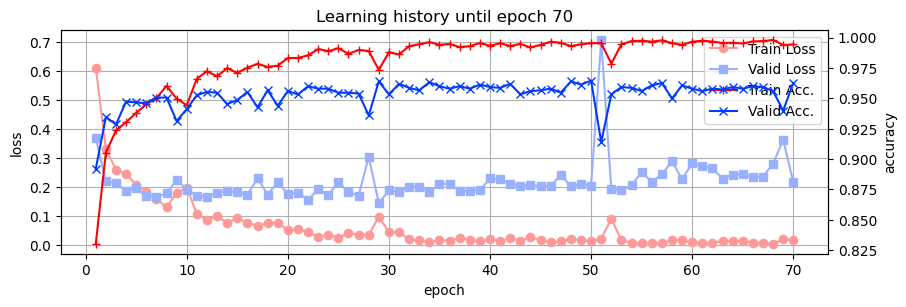

Iter:   70 >> T_loss 0.01838    T_acc 0.99435   V_loss 0.21804    V_acc 0.96262   🕒 13.111s
Iter:   69 >> T_loss 0.02093    T_acc 0.99391   V_loss 0.36408    V_acc 0.93992   🕒 13.172s
Iter:   68 >> T_loss 0.00547    T_acc 0.99807   V_loss 0.28120    V_acc 0.95594   🕒 13.446s
Iter:   67 >> T_loss 0.00898    T_acc 0.99710   V_loss 0.23716    V_acc 0.95928   🕒 13.520s
Iter:   66 >> T_loss 0.00987    T_acc 0.99680   V_loss 0.23533    V_acc 0.95995   🕒 13.873s
Iter:   65 >> T_loss 0.01433    T_acc 0.99517   V_loss 0.24538    V_acc 0.95794   🕒 13.547s
Iter:   64 >> T_loss 0.01388    T_acc 0.99576   V_loss 0.24424    V_acc 0.95928   🕒 14.272s
Iter:   63 >> T_loss 0.01569    T_acc 0.99554   V_loss 0.22998    V_acc 0.95728   🕒 13.383s
Iter:   62 >> T_loss 0.00903    T_acc 0.99673   V_loss 0.26511    V_acc 0.95794   🕒 13.586s
Iter:   61 >> T_loss 0.00802    T_acc 0.99747   V_loss 0.27434    V_acc 0.95594   🕒 13.151s
Iter:   60 >> T_loss 0.01002    T_acc 0.99658   V_loss 0.28231    V_acc 0.95794 

In [163]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=False, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc,_,_ = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [160]:

# Save prediction vector to CSV file

# Before run this code, here put your save path (only for local server not kaggle kernel)
save_root = './test_predft.csv'   # <--- only edit this path

# After run this code, you must check that the shape of 'out' variable is 3745. (out.shape == 3745)


# ============================== Do not edit under this line ==========================================
for _data in test_loader:
    data = _data.to(device)

    # 1. Feed-forward
    onehot_out = net(data)
    _, out = torch.max(onehot_out, 1)
    
print(out.shape)

import csv

# 덮어쓰기 방지를 위해 이미 파일이 존재하면 삭제
if os.path.isfile(save_root):
    os.remove(save_root)

# 첫 행에 'id' 'lable' 그 다음 행부터 idx와 label 넣어서 csv 저장
for idx, pred in enumerate(list(out.cpu())):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['id', 'label'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)
# ============================== Do not edit over this line ==========================================

torch.Size([3745])
